In [1]:
import sys
sys.path.append("/Users/fsolleza/Documents/Projects/timeseries-data") # path to this repository
import py_ts_data

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from auto_encoder import AutoEncoder, train_step

X_train, y_train, X_test, y_test, info = py_ts_data.load_data("Libras", variables_as_channels=True)
print("Dataset shape: Train: {}, Test: {}".format(X_train.shape, X_test.shape))

TS-Data path: /Users/fsolleza/Sandbox/ts-data/data
Dataset shape: Train: (180, 45, 2), Test: (180, 45, 2)


In [2]:
def min_max(data, feature_range=(0, 1)):
    """
    implements min-max scaler
    """
    min_v = feature_range[0]
    max_v = feature_range[1]
    max_vals = data.max(axis=1)[:, None, :]
    min_vals = data.min(axis=1)[:, None, :]
    X_std = (data - min_vals) / (max_vals - min_vals)
    return X_std * (max_v - min_v) + min_v

def normalize(data):
    """
    Z-normalize data with shape (x, y, z)
    x = # of timeseries
    y = len of each timeseries
    z = vars in each timeseres
    
    s.t. each array in [., :, .] (i.e. each timeseries variable)
    is zero-mean and unit stddev
    """
    sz, l, d = data.shape
    means = np.broadcast_to(np.mean(data, axis=1)[:, None, :], (sz, l, d))
    stddev = np.broadcast_to(np.std(data, axis=1)[:, None, :], (sz, l, d)) 
    return (data - means)/stddev


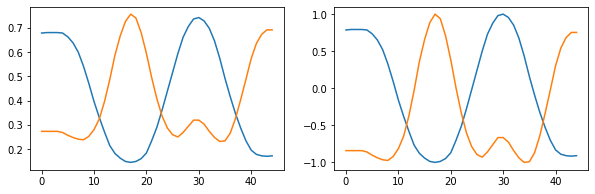

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(X_train[0])
X_train = min_max(X_train, feature_range=(-1, 1))
axs[1].plot(X_train[0])
X_test = min_max(X_test, feature_range=(-1, 1))
plt.show()

# Encode and Decode

In [4]:
kwargs = {
    "input_shape": (X_train.shape[1], X_train.shape[2]),
    "filters": [32, 64, 128],
    "kernel_sizes": [5, 5, 5],
    "code_size": 16,
}

ae = AutoEncoder(**kwargs)

# Training

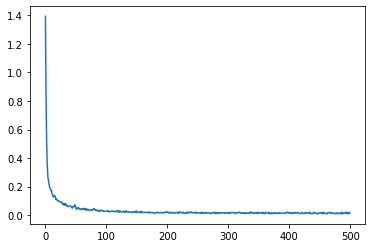

In [5]:
EPOCHS = 500
BATCH = 64
SHUFFLE_BUFFER = 100
K = len(set(y_train))

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER).batch(BATCH)

loss_history = []

for epoch in range(EPOCHS):
    total_loss = 0
    for i, (input, _) in enumerate(train_dataset):
        loss = train_step(input, ae)
    total_loss += loss
    loss_history.append(total_loss)
    print("Epoch {}: {}".format(epoch, total_loss), end="\r")
    
plt.plot(loss_history)

# Test

## Evaluate reconstruction

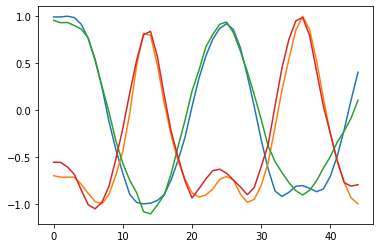

Mean L2 distance: 1.093784213066101


In [6]:
code_test = ae.encode(X_test)
decoded_test = ae.decode(code_test)

plt.plot(X_test[0])
plt.plot(decoded_test[0])
plt.show()

losses = []
for ground, predict in zip(X_test, decoded_test):
    losses.append(np.linalg.norm(ground - predict))
print("Mean L2 distance: {}".format(np.array(losses).mean()))

## Evaluate Similarity

In [7]:
from sklearn.neighbors import NearestNeighbors

def nn_dist(x, y):
    """
    Sample distance metric, here, using only Euclidean distance
    """
    x = x.reshape((45, 2))
    y = y.reshape((45, 2))
    return np.linalg.norm(x-y)

nn_x_test = X_test.reshape((-1, 90))
baseline_nn = NearestNeighbors(n_neighbors=10, metric=nn_dist).fit(nn_x_test)
code_nn = NearestNeighbors(n_neighbors=10).fit(code_test)

# For each item in the test data, find its 11 nearest neighbors in that dataset (the nn is itself)
baseline_11nn = baseline_nn.kneighbors(nn_x_test, 11, return_distance=False)
code_11nn     = code_nn.kneighbors(code_test, 11, return_distance=False)

# On average, how many common items are in the 10nn?
result = []
for b, c in zip(baseline_11nn, code_11nn):
    # remove the first nn (itself)
    b = set(b[1:])
    c = set(c[1:])
    result.append(len(b.intersection(c)))
np.array(result).mean()

8.2